## Neural Networks

The main purpose of this notebook is to help you understand how the process of backpropagation helps us to train a neural network by tuning the weights to maximise predictive accuracy. Readers should be familiar with the general concept of neural networks before attempting to fill in the notebook. 

For a more formal explanation of backpropagation, Bishop's [*Pattern Recognition and Machine Learning*](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) covers it in detail in section 5.3. I found it to be useful to sit down with a pen and paper to draw the network diagrams and map how the inputs and error move forwards and backwards through the network respectively!

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Create Dataset

Use the generative process of a linear model - i.e. a weighted sum of the features plus Gaussian noise

In [2]:
n = 1000 #Number of observations in the training set
p = 5 #Number of parameters, including intercept

beta = np.random.uniform(-10, 10, p) #Randomly initialise true parameters

for i, b in enumerate(beta):
    print(f'\u03B2{i}: {round(b, 3)}')


β0: 2.885
β1: -3.907
β2: 3.059
β3: 1.657
β4: -1.222


In [3]:
X = np.random.uniform(0,10,(n,(p-1))) #Randomly sample features X1-X4
X0 = np.array([1]*n).reshape((n,1)) #X0 is our intercept so always equal to 1
X = np.concatenate([X0,X], axis = 1) #Join intercept to other variables to form feature matrix


In [4]:
Y = np.matmul(X,beta) + np.random.normal(0,10,n) #Linear combination of the features plus a normal error term

In [5]:
#Concatenate to create dataframe
dataFeatures = pd.DataFrame(X)
dataFeatures.columns = [f'X{i}' for i in range(p)] #Name feature columns

dataTarget = pd.DataFrame(Y)
dataTarget.columns = ['Y'] #Name target 

data = pd.concat([dataFeatures, dataTarget], axis = 1)


## Quickly visualise the dataset

In [6]:
print(f'Number of Rows: {data.shape[0]}')
print(f'Number of Columns: {data.shape[1]}')
data.head()

Number of Rows: 1000
Number of Columns: 6


,X0,X1,X2,X3,X4,Y
0,1.0,6.700429,6.303604,0.975621,9.169331,-32.574197
1,1.0,1.573866,7.755068,9.223561,1.044570,43.557103
2,1.0,3.958598,5.975776,6.731622,3.897933,0.089436
3,1.0,2.808166,4.629907,4.230858,7.625144,6.249076
4,1.0,3.263415,5.695659,5.803746,5.311624,-2.923838


## Create a neural network

We'll use a single hidden layer and tanh activation function

In [7]:
class NeuralNetwork:
    
    def __init__(self, data, target, features, hiddenSize, trainTestRatio = 0.9):
        
        self.target = target
        self.features = features 
        
        #Split up data into a training and testing set
        self.train, self.test = train_test_split(data, test_size=1-trainTestRatio)
        
        self.input      = np.array(self.train[self.features])
        self.hiddenSize = hiddenSize
        self.weightsInputToHidden   = np.random.normal(size = (self.input.shape[1],hiddenSize))
        self.weightsHiddenToOutput   = np.random.normal(size = (hiddenSize + 1 ,))   #+1 is for the bias term              
        self.y          = np.array(self.train[self.target])
        self.output     = np.zeros(self.y.shape)
        
        
        #Standardise training set
        self.scaler = StandardScaler()
        self.scaler.fit(self.input)
        self.input = self.scaler.transform(self.input)
        
        #Pre-allocate weight derivatives
        self.dWeightsInputToHidden = np.ones(self.weightsInputToHidden.shape)
        self.dWeightsHiddenToOutput = np.ones(self.weightsHiddenToOutput.shape)

    def feedforward(self):
        
        #Compute hidden activations
        self.a = np.dot(self.input, self.weightsInputToHidden)
        self.z = np.tanh(self.a)
        
        #Add bias term on for the next layer of the network
        self.zWithBias = np.ones((self.input.shape[0], self.hiddenSize + 1))
        self.zWithBias[:, :-1] = self.z
        
        self.z = self.zWithBias
        
        #Compute Output
        self.output = np.dot(self.z, self.weightsHiddenToOutput)

        
    def backpropagation(self):
        
        normFactor = 1/self.input.shape[0] #Normalising factor for the derivatives
        
        #Compute Deltas
        self.deltaOutput = self.output - self.y #Delta for the output node
        self.deltaHidden =[(np.ones(self.input.shape[0]) - (self.z[:, j])**2)*self.weightsHiddenToOutput[j]*self.deltaOutput for j in range(self.weightsHiddenToOutput.shape[0])]

    
        #Compute Weight derivatives:
        self.dWeightsInputToHidden = normFactor * np.matmul(self.deltaHidden,  self.input).T #Transpose to align the dimensions
        self.dWeightsHiddenToOutput = normFactor * np.matmul(self.deltaOutput, self.z)

    def trainNetwork(self, lr = 0.001, numEpochs = 100):
        
        #Train by feeding the data through the network and then backpropagating error a set number (numEpochs) of times
        #Apply gradient descent to update the weights
        #Stop training early if the gradients vanish
        
        ep = 0
        
        
        while ep < numEpochs and (np.linalg.norm(self.dWeightsInputToHidden) + np.linalg.norm(self.dWeightsHiddenToOutput)) > 0.5:
            
            if ep%1000 == 0 and ep > 0:
                print(f'Epoch {ep}')
            
            
            self.feedforward()
            self.backpropagation()
            
            #Update weights
            
            self.weightsInputToHidden = self.weightsInputToHidden - lr * self.dWeightsInputToHidden[:,:-1]
            self.weightsHiddenToOutput = self.weightsHiddenToOutput - lr * self.dWeightsHiddenToOutput
            
            ep += 1
            
        print('Training completed')
            
    def predict(self, x):
        
        #Works in the same way as feedforward:
        
        #First, though, we need to transform the input data
        x = self.scaler.transform(x)
        
        #Compute hidden activations
        self.aPred = np.dot(x, self.weightsInputToHidden)
        self.zPred = np.tanh(self.aPred)
        
        #Adapt the z terms so we can include a bias term to the second layer
        self.zPredWithBias = np.ones((x.shape[0], self.hiddenSize + 1))
        self.zPredWithBias[:, :-1] = self.zPred
        
        self.zPred = self.zPredWithBias
        
        #Compute Output
        return np.dot(self.zPred, self.weightsHiddenToOutput)
        

In [8]:
dataInput = np.array(data[['X0', 'X1', 'X2', 'X3', 'X4']])
dataOutput = np.array(data['Y'])
myNN = NeuralNetwork(data, 'Y', ['X0', 'X1', 'X2', 'X3', 'X4'], 3)

In [9]:
myNN.feedforward()

In [10]:
myNN.trainNetwork(lr= 0.001, numEpochs=200000)

Epoch 1000
Epoch 2000
Epoch 3000
Epoch 4000
Epoch 5000
Epoch 6000
Epoch 7000
Epoch 8000
Epoch 9000
Training completed


## Let's see how our model performs

Lets predict the labels of the held out test set and plot them against the true values

In [11]:
predTest = myNN.predict(myNN.test[myNN.features])

If the poins gather around the line y = x then our model is performing as desired

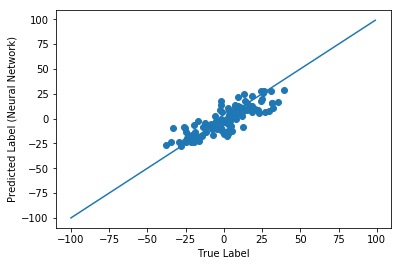

In [12]:
plt.scatter(myNN.test[myNN.target], predTest)
plt.plot(np.arange(-100,100), np.arange(-100,100))
plt.xlabel('True Label')
plt.ylabel('Predicted Label (Neural Network)')
plt.show()

# Summary

In reality, the dataset we used to fit our neural network was not a particularly challenging one due to the relationships between variables being linear - you can check to see that using a linear regression on this dataset would give comparable predictive accuracy.

The value in neural networks, though, lies in their ability to approximate more complex relationships by adding more hidden layers to the model architecture. We will see in the notebooks on 'deeper' neural networks (to be published soon, hopefully!) that such models outperform simpler models in terms of predictive accuracy - now that we've got the hang of backpropagation in the limited case presented in this notebook, it's not a big mental step to extend it to a neural network with any number of hidden layers.